In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
DATA_PATH = "Fish.csv"  # if running here use: "/mnt/data/Fish.csv"
df = pd.read_csv(DATA_PATH)

# Basic cleanup
df.columns = [c.strip() for c in df.columns]
df = df.drop_duplicates().reset_index(drop=True)

# Handle missing (drop missing target, impute features later in pipelines)
df = df.dropna(subset=["Weight"])

In [4]:
df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


In [5]:
def add_features(d):
    d = d.copy()
    # Numeric base columns present in Kaggle Fish Market
    # Species, Weight, Length1, Length2, Length3, Height, Width
    d["LengthAvg"] = (d["Length1"] + d["Length2"] + d["Length3"]) / 3.0
    d["L3xW"] = d["Length3"] * d["Width"]
    d["HxW"] = d["Height"] * d["Width"]
    # Aspect-style ratio (avoid div-by-zero)
    d["AspectHW"] = d["Height"] / np.where(d["Width"]==0, 1e-6, d["Width"])
    return d

df = add_features(df)

In [6]:
df

,Species,Weight,Length1,Length2,Length3,Height,Width,LengthAvg,L3xW,HxW,AspectHW
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,26.200000,120.60000,46.310400,2.865672
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,27.166667,134.33472,53.733888,2.898551
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,27.166667,146.04871,58.127387,2.635762
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,29.600000,149.25925,56.718515,2.857143
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,29.833333,174.55600,63.887496,2.423841
...,...,...,...,...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936,12.366667,18.67424,2.913181,1.500000
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690,12.533333,17.13150,3.083670,1.914894
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558,12.966667,17.33004,2.859457,1.813187
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672,14.233333,31.42144,5.938652,1.389706


In [7]:
Q1, Q3 = df["Weight"].quantile([0.25, 0.75])
IQR = Q3 - Q1
low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
df = df[(df["Weight"] >= low) & (df["Weight"] <= high)].reset_index(drop=True)

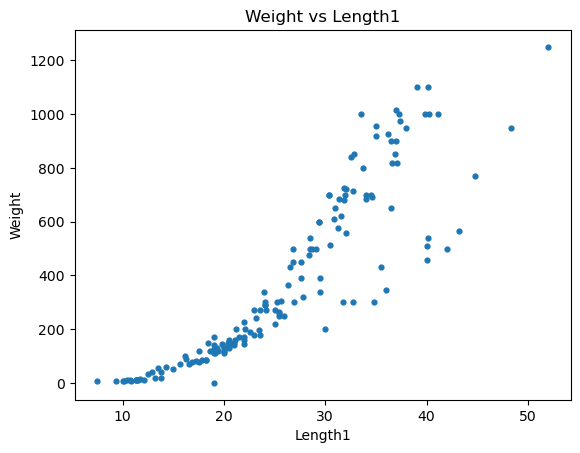

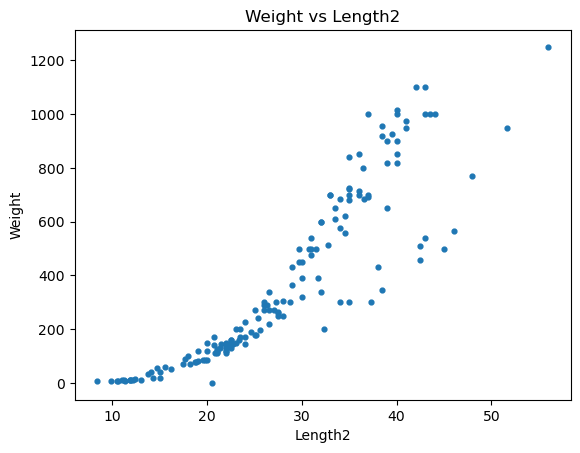

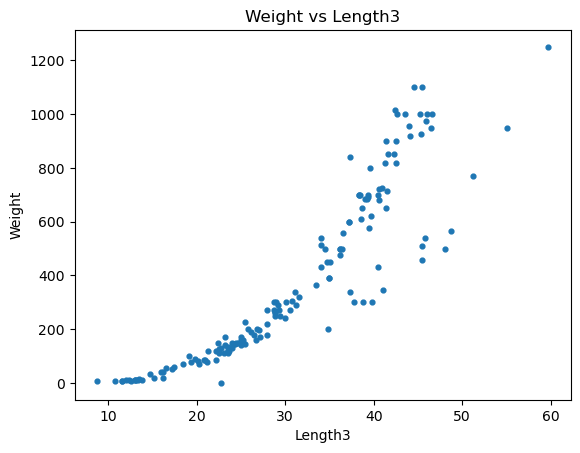

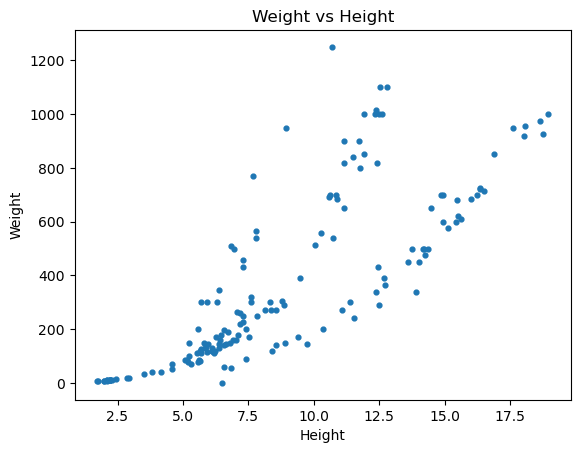

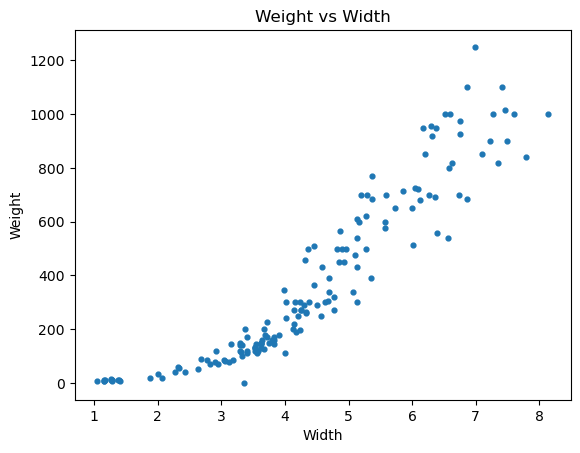

In [8]:
num_cols_basic = ["Length1","Length2","Length3","Height","Width"]
for col in num_cols_basic:
    plt.figure()
    plt.scatter(df[col], df["Weight"], s=12)
    plt.xlabel(col); plt.ylabel("Weight"); plt.title(f"Weight vs {col}")
    plt.show()

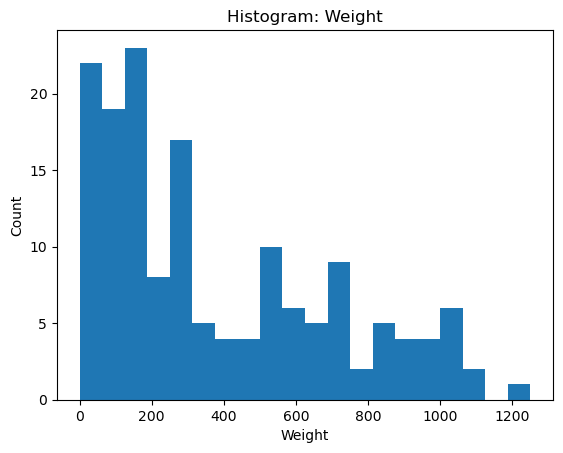

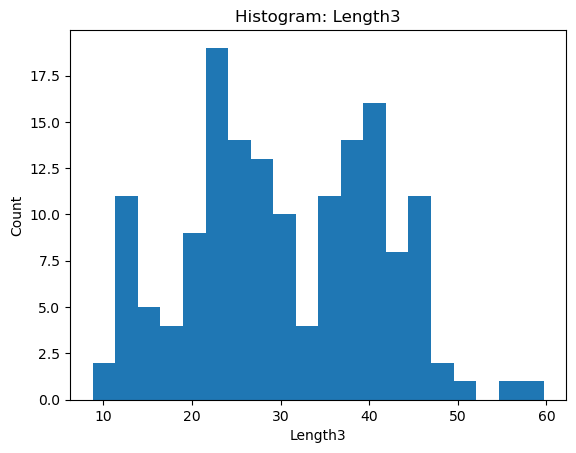

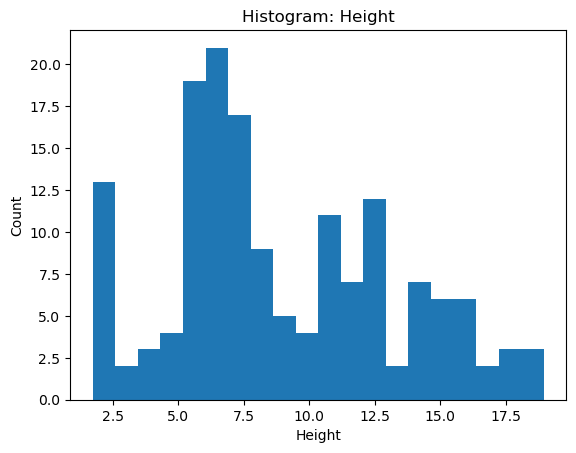

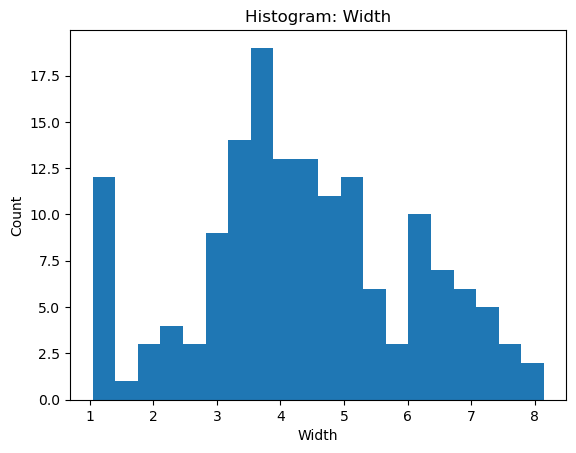

In [9]:
for col in ["Weight","Length3","Height","Width"]:
    plt.figure()
    plt.hist(df[col], bins=20)
    plt.xlabel(col); plt.ylabel("Count"); plt.title(f"Histogram: {col}")
    plt.show()

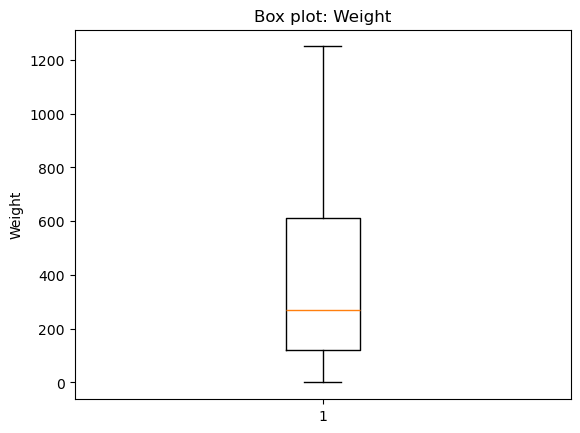

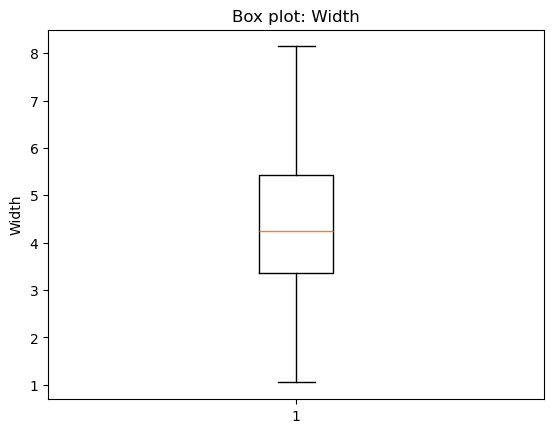

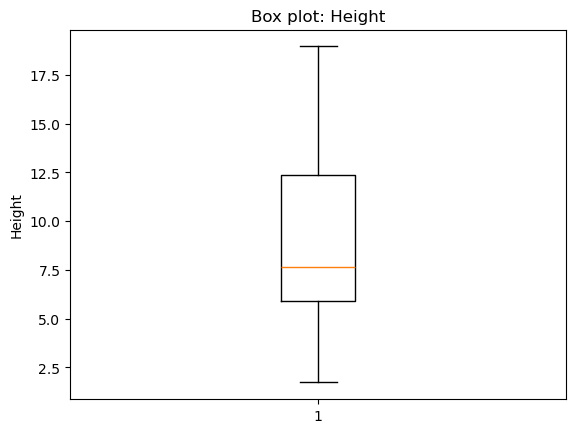

In [10]:
for col in ["Weight","Width","Height"]:
    plt.figure()
    plt.boxplot(df[col].dropna().values, vert=True)
    plt.title(f"Box plot: {col}")
    plt.ylabel(col)
    plt.show()

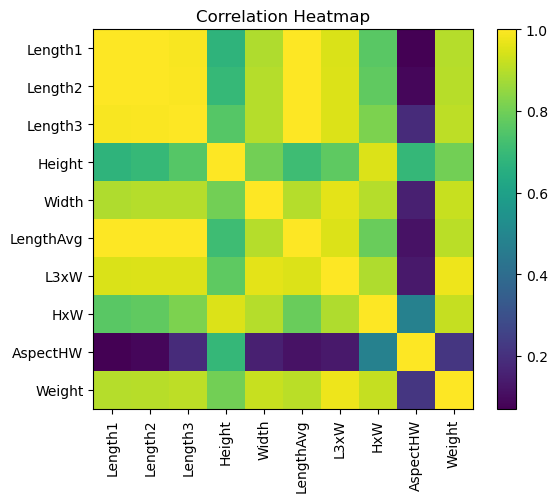

In [11]:
corr = df[num_cols_basic + ["LengthAvg","L3xW","HxW","AspectHW","Weight"]].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.yticks(range(corr.shape[0]), corr.index)
plt.colorbar()
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [12]:
target = "Weight"
features = ["Species","Length1","Length2","Length3","Height","Width",
            "LengthAvg","L3xW","HxW","AspectHW"]

X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_features = ["Length1","Length2","Length3","Height","Width",
                    "LengthAvg","L3xW","HxW","AspectHW"]
categorical_features = ["Species"]

In [13]:
num_basic = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_basic = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_basic = ColumnTransformer([
    ("num", num_basic, numeric_features),
    ("cat", cat_basic, categorical_features)
])


In [14]:
num_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])
preprocessor_poly = ColumnTransformer([
    ("num_poly", num_poly, numeric_features),
    ("cat", cat_basic, categorical_features)
])


In [26]:
from sklearn.linear_model import LassoCV
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # optional

models = {
    "LinearRegression": Pipeline([
        ("prep", preprocessor_basic),
        ("model", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("prep", preprocessor_basic),
        ("model", Ridge(alpha=1.0))
    ]),
    "Lasso": Pipeline([
        ("prep", preprocessor_basic),
        ("model", LassoCV(cv=5, n_alphas=100, max_iter=200000, tol=1e-3))
    ]),
    "Polynomial(d=2)": Pipeline([
        ("prep", preprocessor_poly),
        ("model", LinearRegression())
    ]),
}

def evaluate(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, preds))  # robust to older sklearn
    r2 = r2_score(y_te, preds)
    return rmse, r2, preds

results, trained = [], {}
for name, pipe in models.items():
    rmse, r2, preds = evaluate(pipe, X_train, y_train, X_test, y_test)
    trained[name] = pipe
    results.append({"Model": name, "RMSE": rmse, "R2": r2})

metrics_df = pd.DataFrame(results).sort_values("RMSE")
print("\n=== Test Metrics ===")
print(metrics_df.to_string(index=False))

best_name = metrics_df.iloc[0]["Model"]
best_model = trained[best_name]
print(f"\nBest model by RMSE: {best_name}")

# (Optional) show chosen alpha for LassoCV
if "Lasso" in trained and hasattr(trained["Lasso"].named_steps["model"], "alpha_"):
    print("LassoCV alpha_:", trained["Lasso"].named_steps["model"].alpha_)

# helper stays the same:
def estimate_fish_weight(species, length1, length2, length3, height, width):
    row = pd.DataFrame([{
        "Species": species,
        "Length1": length1,
        "Length2": length2,
        "Length3": length3,
        "Height": height,
        "Width": width
    }])
    row = add_features(row)
    return float(best_model.predict(row)[0])

# example:
w = estimate_fish_weight("Bream", 23.0, 25.0, 27.0, 12.0, 4.0)
print("Estimated Weight:", round(w, 2))


C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1613: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(



=== Test Metrics ===
           Model      RMSE       R2
LinearRegression 35.496175 0.987947
           Lasso 35.922583 0.987656
           Ridge 39.600395 0.984999
 Polynomial(d=2) 49.536139 0.976527

Best model by RMSE: LinearRegression
LassoCV alpha_: 0.3098660636109578
Estimated Weight: 247.34
